<h2 style = "text-align:center" ><b>EEG</b> - Prédiction des Mouvements Imaginaires de la Main</h2>

---

# **1. Description du projet**
- Introduction :  
L’électroencéphalogramme (EEG) est une technique d’imagerie cérébrale utilisée pour étudier les activités du cerveau.  
En plaçant des capteurs sur le cuir chevelu, l’activité électrique du cerveau est enregistrée, ce qui permet de comprendre les fonctionnements cérébraux et d’identifier certains schémas que l’on peut ensuite attribuer à des comportements précis.  
Un des schémas d'EEG qui a été beaucoup étudié est l’imagerie motrice (IM), ou le mouvement imaginaire de la main.  
Les IM créent des schémas bien définis qui peuvent être détectés.  
Le but de ce projet est de créer et d’entraîner un programme permettant de prédire si l’IM d’une personne correspond à un mouvement de la main droite ou de la main gauche.  
# **2. Étapes du projet**
- Prétraitement des Données :  
Les données EEG sont sujettes à des artefacts ou des erreurs de collecte dues à des mouvements parasites ou des interférences.  
Il est donc nécessaire d'appliquer un système de prétraitement des données pour réduire le bruit et extraire les bandes de fréquences pertinentes.

- Segmentation des données et extraction des caractéristiques :  
Les données EEG sont présentées comme un flux continu. Il est donc important, pour une meilleure analyse, de diviser les données en segments temporels correspondant à l’IM.  
Ensuite, identifier et extraire les caractéristiques pertinentes des signaux EEG associées aux IM est essentiel.  
Cela comprend la puissance et d'autres spécificités de l’activité électrique qui définissent les IM.

- Analyse statistique exploratoire :  
Utiliser les outils d’analyse exploratoire pour mieux comprendre les données et identifier les tendances ou les patterns significatifs.

- Entraînement du modèle :  
Entraîner un modèle permettant de distinguer les différences entre les IM des mains droite et gauche.  
Optimiser le modèle et évaluer sa performance sur un ensemble de test.

- Conclusion :  
Ces étapes sont cruciales pour développer un programme efficace de prédiction des mouvements imaginaires de la main basé sur les données EEG.
# **3. Ressources**
- Données   
https://www.kaggle.com/competitions/ucsd-neural-data-challenge/overview  
- Bibliographie  
https://www.bbci.de/competition/iv/desc_2b.pdf
# **4. Liens utils**
- SciPy - *open-source software for mathematics, science, and engineering*  
https://docs.scipy.org/doc/scipy/index.html  
https://docs.scipy.org/doc/scipy/reference/signal.html  
- MNE - *MEG + EEG Analysis & Visualisation*
   - Accueil  
   https://mne.tools/stable/index.html

   - MNE - Data structures from arbitrary data  
   https://mne.tools/stable/auto_tutorials/io/10_reading_meg_data.html#creating-mne-data-structures-from-arbitrary-data-from-memory
   
   - MNE - EEG Preprocessing  
   https://mne.tools/dev/auto_tutorials/preprocessing/index.html  

- pyRiemann - *Biosignals classification with Riemannian geometry*  
https://pyriemann.readthedocs.io/en/latest/  
- neurodsp - *Neuro Digital Signal Processing Toolbox*  
https://neurodsp-tools.github.io/neurodsp/index.html#
- Rythme Mu  
https://fr.wikipedia.org/wiki/Rythme_Mu
- Divers  
https://signalprocessingsociety.org/  
https://fr.wikipedia.org/wiki/Filtre_de_Butterworth  
https://fr.wikipedia.org/wiki/Moyenne_mobile  
https://terpconnect.umd.edu/~toh/spectrum/Differentiation.html  
https://perso.etis-lab.fr/ghaffari/2014_CCMB_Floride_USA.pdf  
https://www.youtube.com/watch?v=wB417SAbdak&list=PLXc9qfVbMMN2TAoLHVW5NvNmJtwiHurzw  
https://fastercapital.com/fr/sujet/identification-des-artefacts-de-traitement-du-signal-dans-des-sc%C3%A9narios-r%C3%A9els.html#:~:text=L'inspection%20visuelle%20est%20la,des%20pertes%20et%20du%20bruit.  
   - Z-Score Normalisation  
   https://fr.wikipedia.org/wiki/Cote_Z_(statistiques)  
   https://typeset.io/questions/why-is-z-score-normalisation-necessary-in-pre-processing-eeg-1xv5jepyq5  

   - Traitement numérique du signal  
   https://fr.wikipedia.org/wiki/Traitement_num%C3%A9rique_du_signal  
   - Ondelette  
      - Wiki  
      https://fr.wikipedia.org/wiki/Ondelette  

      - L’analyse par ondelettes dans la vie de tous les jours  
      https://interstices.info/lanalyse-par-ondelettes-dans-la-vie-de-tous-les-jours/  

      - A guide for using the Wavelet Transform in Machine Learning  
      https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
      
      - pyWavelets - *open source wavelet transform*  
      https://pywavelets.readthedocs.io/en/latest/

      - Ondelettes et applications  
      https://www.i2m.univ-amu.fr/~caroline.chaux/GEOMDATA/TI-te5215.pdf

   - Maximum de vraisemblance  
   https://pmarchand1.github.io/ECL8202/notes_cours/03-Maximum_vraisemblance.html  
   https://fr.wikipedia.org/wiki/Maximum_de_vraisemblance#:~:text=En%20statistique%2C%20l'estimateur%20du,maximisant%20la%20fonction%20de%20vraisemblance  

   - Transformation de Fourier discrète  
   https://fr.wikipedia.org/wiki/Transformation_de_Fourier_discr%C3%A8te  
      - La Transformation de Fourier n’est pas adaptée à l’analyse des signaux non stationnaires.
   - Neural Data Science in Python  
   https://neuraldatascience.io/intro.html

   - Preprocessing of EEG  
   https://www.frontiersin.org/articles/10.3389/fninf.2015.00016/full#:~:text=The%20depositable%20preprocessing%20pipeline%20consists,with%20a%20low%20recording%20SNR  
   https://typeset.io/papers/preprocessing-of-eeg-4go8vhcbty  
   https://learn.neurotechedu.com/preprocessing  
   https://g0rella.github.io/gorella_mwn/preprocessing_eeg.html  
   
   - Biblio :  
   https://perso.telecom-paristech.fr/bloch/P6Image/ondelettestrsp.pdf  
   https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/ondelettesIMAT.pdf  
   http://w3.cran.univ-lorraine.fr/perso/radu.ranta/pdf/cours_deb_ond%28fr%29.pdf
   
   - Digital Filtering  
   http://notebooks.pluxbiosignals.com/notebooks/Categories/Pre-Process/digital_filtering_eeg_rev.html

   - Processus stationnaire  
   https://fr.wikipedia.org/wiki/Processus_stationnaire

   - Analyse en composantes principales  
   https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales#:~:text=L'ACP%2C%20d%C3%A9sign%C3%A9e%20en%20g%C3%A9n%C3%A9ral,une%20grandeur%20physique%2C%20comme%20les

In [1]:
import pandas as pd
import numpy as np

import scipy as sc
import mne

from scipy.fft import fft
from zipfile import ZipFile

from scipy import signal #, stats , fft, fftfreq

In [2]:
from sklearn import preprocessing, model_selection, ensemble, svm, neighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier

In [3]:
### Deprecated

### Ce DataFrame sera utilisé pour l'étude de des signaux.
# @deprecated("Plus utilisé dans le cadre de ce projet")
def fancy_df(df : pd.DataFrame, events : list, hands : dict, size : int,
             expend : int = 0) -> tuple[pd.DataFrame, list] : # deprecated
    df_cpy = pd.DataFrame({'C3_4'  : df[['C3', 'C4']].sum(axis = 1), # Somme des signaux 'C3' et 'C4'.
                            # 'EventStart' : df['EventStart'],       # Survenue d'un évènement lié à une des mains.
                           'Hand'  : 0,                              # Activité liée à l'une des mains.
                           'Left'  : 0,                              # Activité liée à la main gauche.
                           'Right' : 0})                             # Activité liée à la main droite.
    evts  = list(zip(np.where(df['EventStart'] == 1)[0], events))
    size += 2 * expend
    # df_cpy['zCore'] = stats.zscore(df['C3_4'])

    for i, j in evts :
        i                        -= expend
        fin                       = range(i, i + size)
        df_cpy.loc[fin, 'Hand']   = np.ones(size)
        df_cpy.loc[fin, hands[j]] = np.ones(size)

    return df_cpy, evts # [i[0] for i in evts]

### 
# @deprecated("Plus utilisé dans le cadre de ce projet")
def left_right_old(df : pd.DataFrame, events : list, size : int, canals, hand : int = 0,
                      expend : int = 0) -> pd.DataFrame :
    lp    = range(len(canals))
    res   = [[] for _ in lp]
    size += expend * 2

    for i in events :
        i   -= expend
        fin = range(i, i + size)

        for k, c in enumerate(canals) :
            res[k] = np.append(res[k], df.loc[fin, c].values)

    return pd.DataFrame({'signal_epoched' : res, 'canal' : canals, 'hand' : hand, 'data_split' : [events for _ in lp]})

In [26]:
### https://pandas.pydata.org/docs/reference/io.html
def pickle_in_zip(fichier_zip : str, fichier_specifique : str) -> pd.DataFrame :
    with ZipFile(fichier_zip).open(fichier_specifique) as f :
        return pd.read_pickle(f)

### https://pandas.pydata.org/docs/reference/io.html
def csv_in_zip(fichierZip : str, repertoir : str = None, fichiers : list | str = None) \
        -> list[pd.DataFrame] : #,  merge : bool = False | pd.DataFrame
    res = []
    dir = '' if ((repertoir is None) | (repertoir == '')) else (repertoir + '/')

    with ZipFile(fichierZip) as myzip :
        filtre = myzip.infolist() if dir == '' else \
                 [fic for fic in myzip.infolist() if dir in fic.filename]

        if fichiers != None :
            files  = [dir + X for X in fichiers]
            filtre = [X for X in filtre if (X.filename in files)]

        for fic in filtre :
            with myzip.open(fic.filename) as f :
                res.append(pd.read_csv(f, encoding_errors = 'ignore'))

    return res

### 
def hand_out(df : pd.DataFrame, events : list, size : int, canals, hand : int = 0,
             expend : int = 0) -> pd.DataFrame :
    res    = pd.DataFrame()
    size  += expend * 2
    signal = [f'S_{i}' for i in range(size)]
    
    for i in events :
        i   -= expend
        fin  = range(i, i + size)
        part = [{**{'data_split' : i},
                 **dict(zip(signal, df.loc[fin, c])),
                 **{'hand' : hand, f'{c}_dum' : 1}} for c in canals]
        res  = pd.concat([res, pd.DataFrame(part)])

    return res

### Pour récupérer les évènement relatifs à la survenue d'une action associcée aux mains
def share_out(df : pd.DataFrame, event0 : list[int], event1 : list[int], size : int,
              canals : list[str], expend : int = 0) -> pd.DataFrame :
    hand0 = hand_out(df, event0, size, canals, 0, expend)
    hand1 = hand_out(df, event1, size, canals, 1, expend)
    res   = pd.concat([hand0, hand1])

    res.reset_index(drop = True, inplace = True)

    return res

### Coefficients du filtre Butterworth pour filtrage passe-bande
def butter_bandpass(lowcut : float, highcut : float, fs : int, order : int = 4) \
        -> tuple[np.array, np.array] :
    return signal.butter(order, 2 * np.array([lowcut, highcut]) / fs, btype = 'band')

### Filtre passe-bande (avec les coefficients b et a issus de la décomposition de Butterworth)
def bandpass_filter(data : list, b : list, a : list) -> np.array :
    return signal.filtfilt(b, a, data)

### Filtre Notch 
def notch_filter(data : list, freq : float, fs : float, window : int, order : int,
                           ripple : float = None, filter_type : str = None) -> np.array :
    b, a = signal.iirfilter(order, ((2 * freq) + np.array([-window, window])) / fs,
                            rp = ripple, btype = 'bandstop', analog = False, ftype = filter_type)
    
    return signal.lfilter(b, a, data)

### Calcul de l'énergie du signal dans une fenêtre glissante
def signal_energy(data : list, window_size : int) -> np.array :
    energy = [np.sum(data[i : i + window_size] ** 2) for i in range(len(data) - window_size)]

    return np.pad(np.array(energy), (0, window_size), 'constant')

###
def moving_average(serie : list, w : int = 3) -> list[float] :
    res = serie.cumsum() / w

    return np.append(np.zeros(w), res[w: ] - res[: -w])

### https://fr.wikipedia.org/wiki/Lissage_exponentiel
def simple_exponential_smoothing(serie : list, alpha : float = 1, s0 : float = None) -> list[float] :
    res  = serie[0] if s0 is None else s0
    beta = 1 - alpha

    for x in serie :
        res.append(alpha * x + beta * res[-1])

    return res

###
def simple_thresholding(serie : list) -> tuple[float, list] :
    peak = np.max(np.abs(serie))

    return peak, serie / peak

###
def value_aggregator(data : list) -> np.array :
    res  = [data[0]]                 # On enlève le dernier sample
    last = res[-1] + 1               # Rajouté ici pour le calcul des différences.
    
    for i in data[1 : ] :
        if i - last > 1 :
            res.append(last)
            res.append(i)

        last = i

    return np.append(res, last)

### Runs are separated by 100 missing values, encoded as the negative maximum values.
### D'après la définition il y a 100 valeurs continue. Mais, on ne tiendra pas compte de cette information.
def run_slicer(raw : list, step : int = 100) -> np.array :
    res = np.where(abs(raw) >= step)[0]

    if len(res) == 0 : return [range(0, len(raw))]
    
    runs = value_aggregator(res)

    return [range(a, b) for a, b in zip(np.append(0, runs[1 :: 2] + 1), np.append(runs[0 :: 2], len(raw)) - 1)]       

In [41]:
### Ploting

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

### Visualiser le signal original et les bandes de fréquences filtrées
def plot_wavelets(raw : list, signals : dict[str, list], label : str = '') -> None :
    _, ax = plt.subplots(nrows = 2, figsize = (8, 3.7), sharex = 0)
    # _, ax = plt.subplots(nrows = len(signals) + 1, figsize = size) #, ncols = 1, sharex = 0, ncols = 3 # , size : tuple[float, float] = (22, 8)
    x_ticks = raw.index
    
    me : plt.axes = ax[0]

    me.plot(raw, label = 'Raw signal')
    me.legend(loc = 'upper right')

    if label != None : me.set_title(label) # (f'({label}) : ' if label != '' else '') + " "
    
    me = ax[1]

    for i, (band, signal) in enumerate(reversed(signals.items())) :
        # me = ax[i + 1]

        me.plot(pd.Series(signal, x_ticks), label = f'{band}', c = np.random.rand(1, 3)[0])
        me.legend(loc = 'upper right')

    plt.tight_layout()
    plt.show();

###
def plot_window(df : pd.DataFrame, cols : list | str, start : int = 0, size : int = None) -> None :
    size : int = (df.shape[1] - start) if (size is None) else size
    end  : int = start + size
    
    if type(cols) is list :
        for c in cols :
            if '+' in c :
                plt.plot(df[[x.strip() for x in c.split('+')]][start : end].sum(axis = 1), label = c);
            else :
                plt.plot(df[c][start : end], label = c);
    else :
        plt.plot(df[cols][start : end], label = c);

###
def plot_psd(datas : list[pd.DataFrame], rate : int, titles : list[str] = None) -> None :
    n = len(datas)
    k = 1 << 9

    fig, ax = plt.subplots(nrows = n // 3, ncols = 3, figsize = (20, n))
    fig.tight_layout(pad = 3.5)

    for i, df in enumerate(datas) :
        me : plt.axes = ax[i // 3, i % 3]

        if titles != None : me.set_title(titles[i])
            
        for a in ['C3', 'C4', 'Cz'] :
            me.psd(df[a], NFFT = k, Fs = rate, label = f'{a}({i})')
            # me.title(f'Jeu de données({i})')
            me.legend(loc = 'upper right');

    plt.show();

###
def plot_signal(data : pd.DataFrame, parts : list[tuple[int, int]], hand_0 : list[int],
                hand_1 : list[int], canals : list[str], title : str = '') -> None :
    k     = 2 if len(parts) > 1 else 1
    _, ax = plt.subplots(nrows = 3 * k, figsize = (24, 6 * k))
    w     = 1000

    for i, col in enumerate(canals) :
        j     = (i << 1) if len(parts) > 1 else i
        df    = data[col]
        seuil = df.quantile(q = .9975) * 2
        xmax  = len(df)
        h     = seuil * 2

        me : plt.axes = ax[j + 0]

        me.plot(df, c = 'gray', label = col, zorder = -1)
        
        for x in hand_0 :
            me.add_patch(Rectangle((x, -seuil), width = w, height = h, color = '#793F22', alpha = .75))
        for x in hand_1 :
            me.add_patch(Rectangle((x, -seuil), width = w, height = h, color = '#1B4E88', alpha = .75))

        me.hlines(-seuil, xmin = 0, xmax = xmax, colors = '#D03C01')
        me.hlines( seuil, xmin = 0, xmax = xmax, colors = '#D03C01')
        me.legend(loc = 'upper right');
        
        if len(parts) > 1 :
            me : plt.axes = ax[j + 1]

            for x in parts :
                me.plot(df[x], zorder = -1)
            for x in hand_0 :
                me.add_patch(Rectangle((x, -seuil), width = w, height = h, color = '#793F22', alpha = .75))
            for x in hand_1 :
                me.add_patch(Rectangle((x, -seuil), width = w, height = h, color = '#1B4E88', alpha = .75))

            me.hlines(-seuil, xmin = 0, xmax = xmax, colors = '#D03C01')
            me.hlines( seuil, xmin = 0, xmax = xmax, colors = '#D03C01')

    if title != '' : ax[0].set_title(title)
    plt.show();

###
def spectrogram_from_EEG(raw_data : list, Sampling_rate : int, prior_cut_off : int = 0,
                        later_cut_off : int = 120, axe : plt.axes = None) -> None :
    f, t, Sxx = signal.spectrogram(raw_data, fs = Sampling_rate)

    prior = int(prior_cut_off * len(f) / f[-1])
    later = int(later_cut_off * len(f) / f[-1])

    (plt if axe is None else axe).pcolormesh(t, f[prior : later], Sxx[prior : later], shading = 'gouraud')
    
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (sec)")

In [16]:
### Constantes

# Fréquence d'échantillonnage - Hz (Nombre de valeur / sec)
SAMPLE_RATE  = 250
# Nombre d'échantillon consectutif (4" . SAMPLE_RATE)
scope        = 4 * SAMPLE_RATE
# Les bandes de fréquences d'intérêt
bands        = {'Delta': (.1, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30), 'Gamma': (30, 100)}
# Correspondance pour la classification
hands        = {0 : 'Left', 1 : 'Right'}
# Trois enregistrements bipolaires (C3, C4 et Cz)
eeg_canals   = ['C3', 'C4', 'Cz']
# Coefficients pour filtres Butterworth numérique d'ordre N pour le filtrage passe-bande
butter_coeff = {band : butter_bandpass(low, high, SAMPLE_RATE) for band, (low, high) in bands.items()}

In [28]:
path  = "../data/data.zip"
span  = range(1, 6)
fics  = [f'B0{i}0{j}T.csv' for i in span for j in range(1, 4)]
notes = [x.split('.')[0] for x in fics]

df_train_csv = csv_in_zip(path, repertoir = 'train', fichiers = fics)
df_label_csv = csv_in_zip(path, repertoir = 'y_train_only', fichiers = fics)

# df_train_pkl = pkl_in_zip(path, fichier_specifique = 'epoched_train.pkl')

In [29]:
hands0 = []
hands1 = []
parts  = []

for i in range(len(df_train_csv)) :
    cut        = np.where(df_train_csv[i]['EventStart'] == 1)[0]
    event_type = list(df_label_csv[i]['EventType'])
    
    parts.append(run_slicer(df_train_csv[i]['C3'], 75))
    hands0.append([x for i, x in enumerate(cut) if event_type[i] == 0]) 
    hands1.append([x for i, x in enumerate(cut) if event_type[i] == 1])

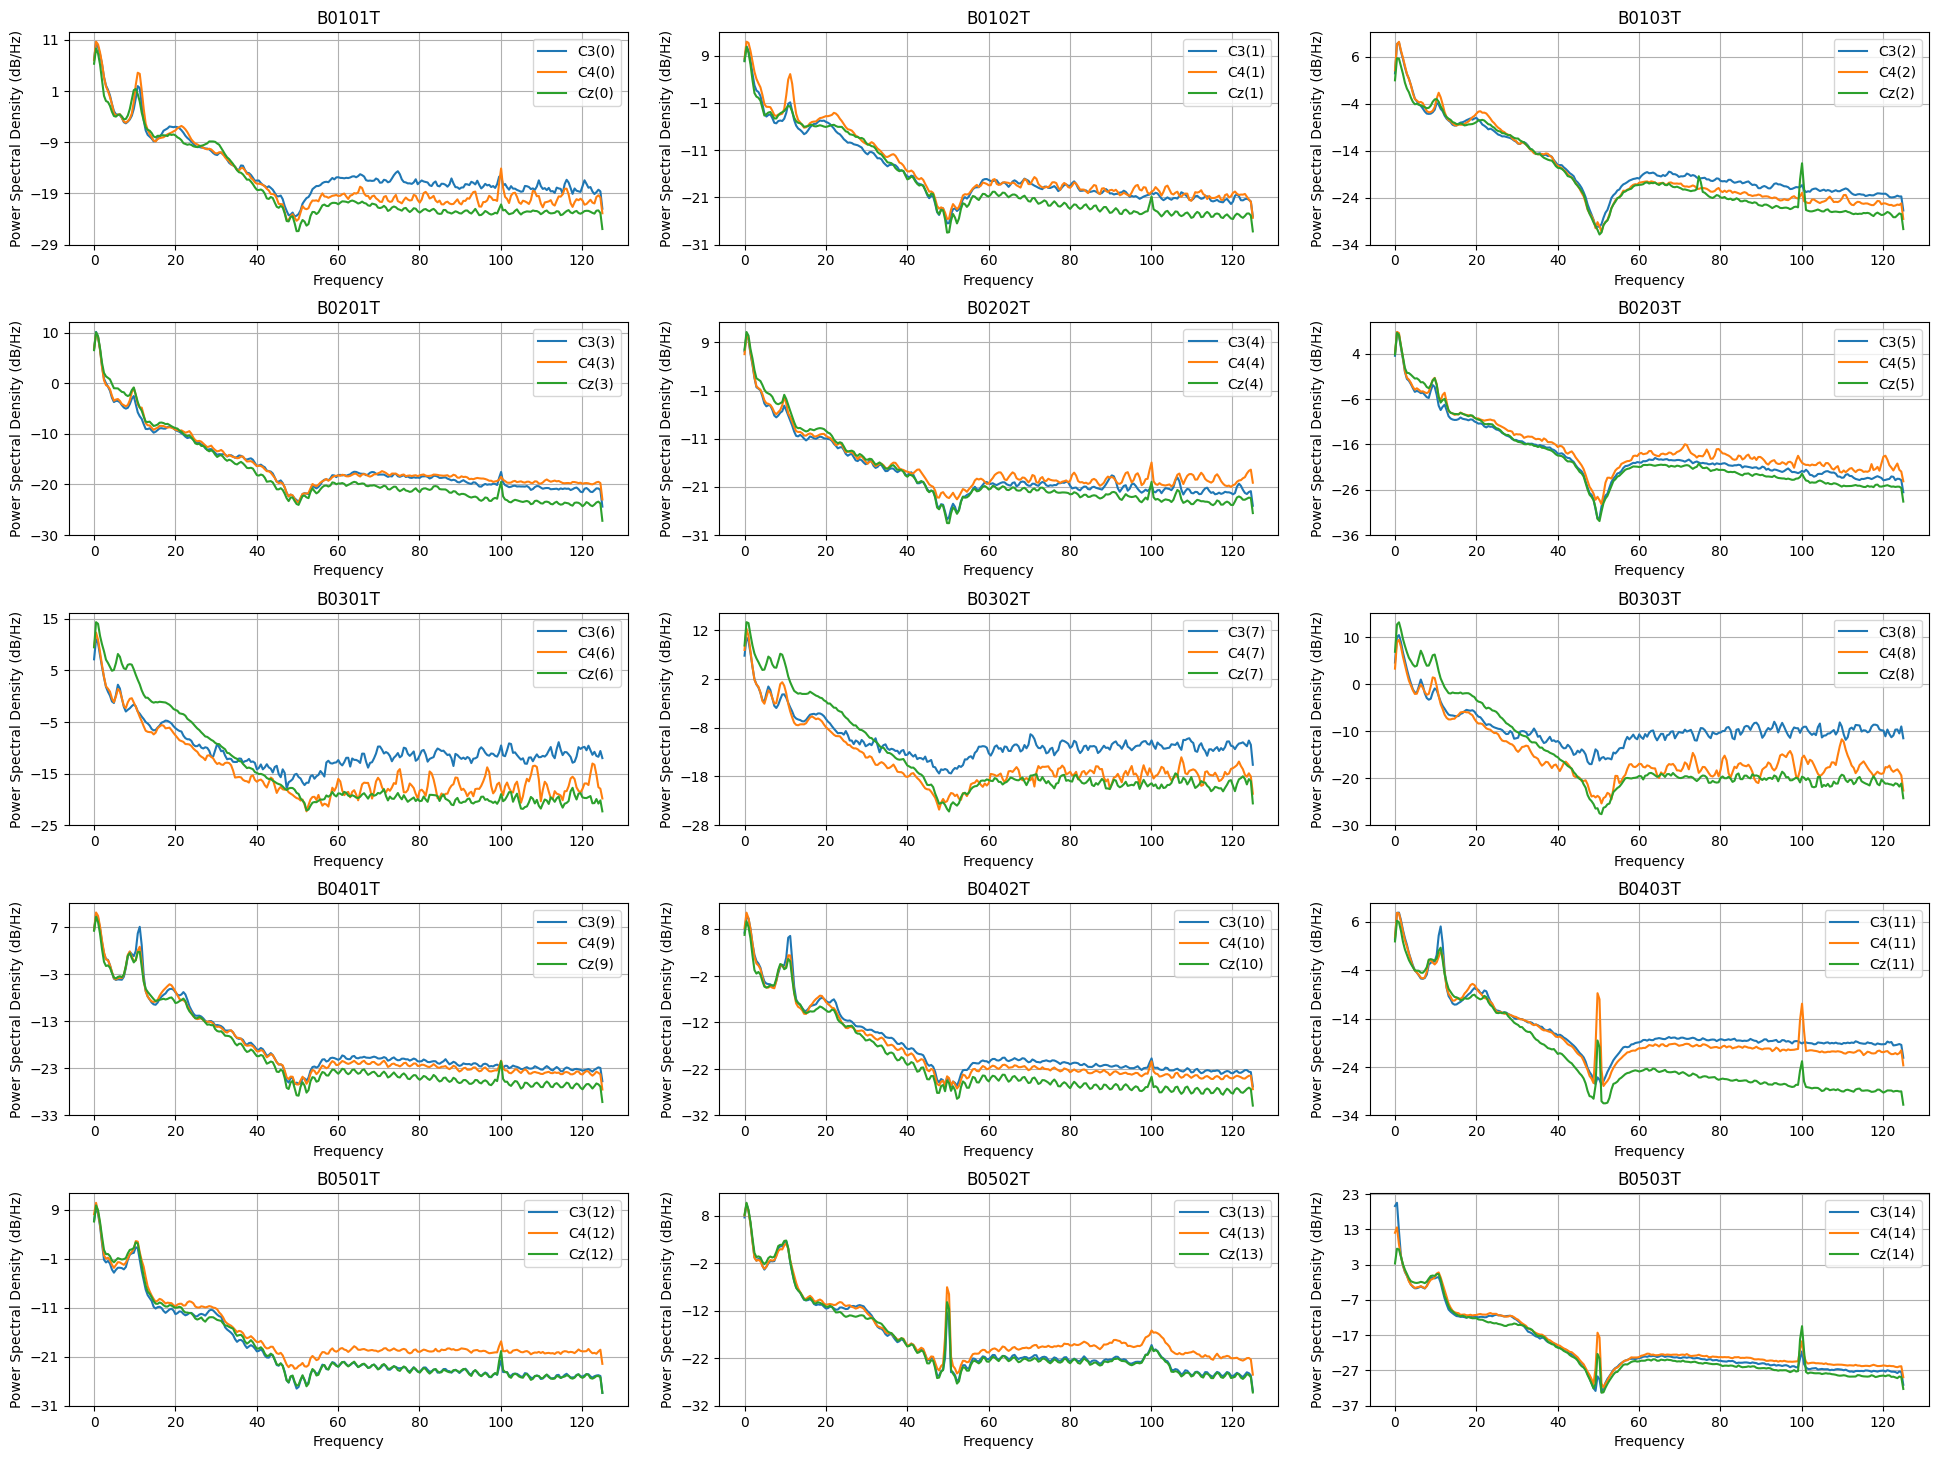

In [42]:
plot_psd(df_train_csv, SAMPLE_RATE, notes)

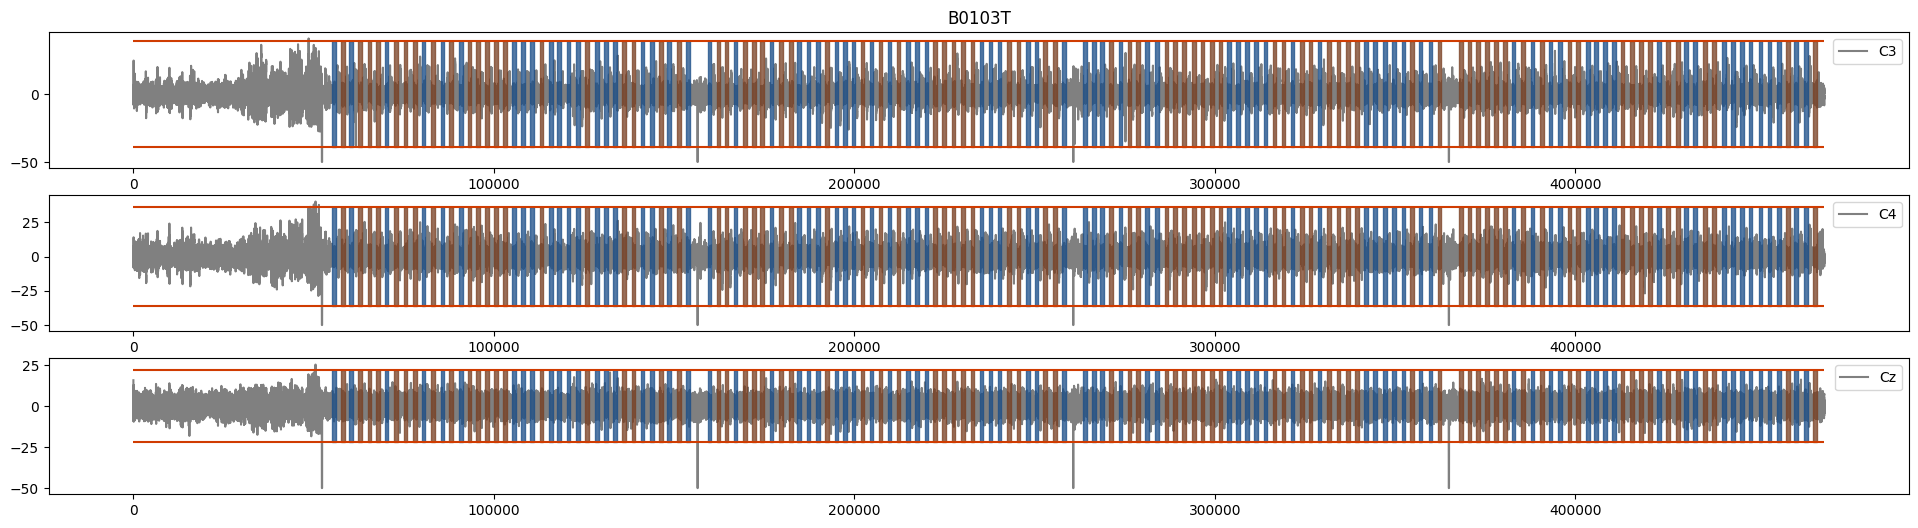

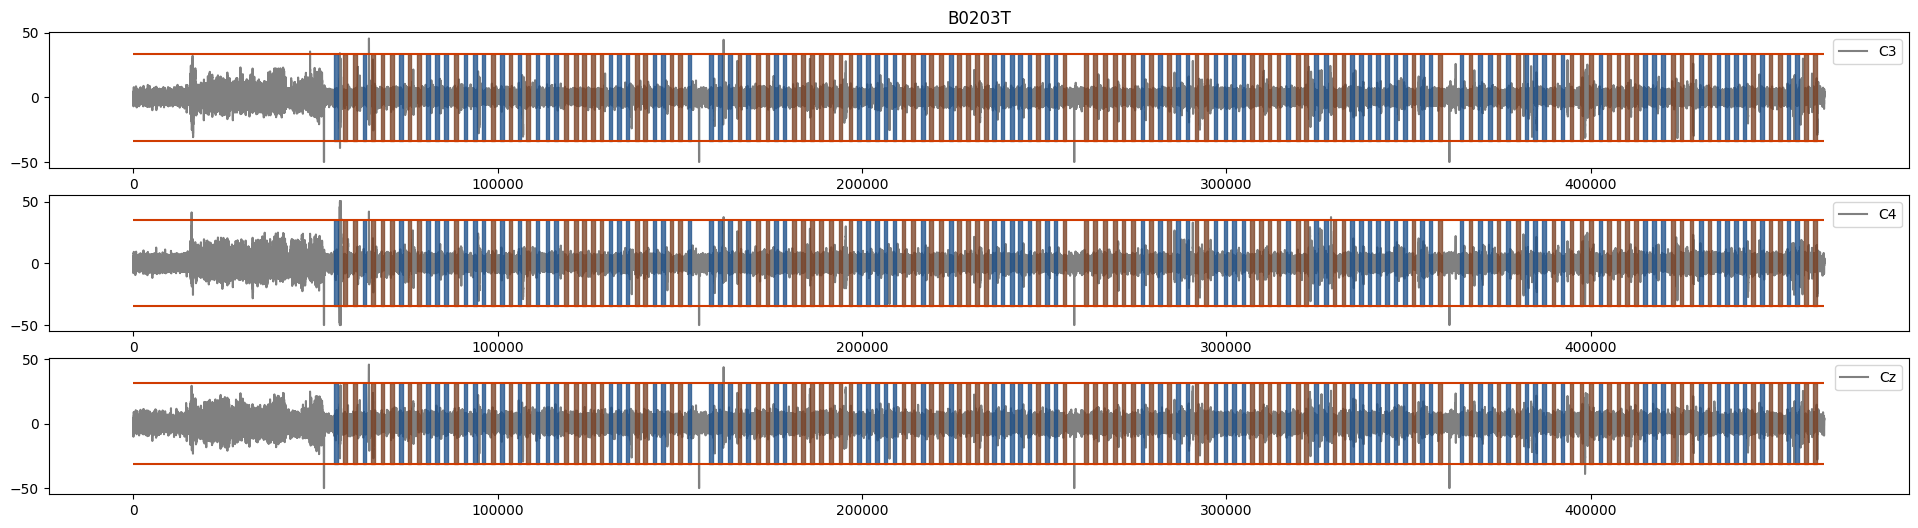

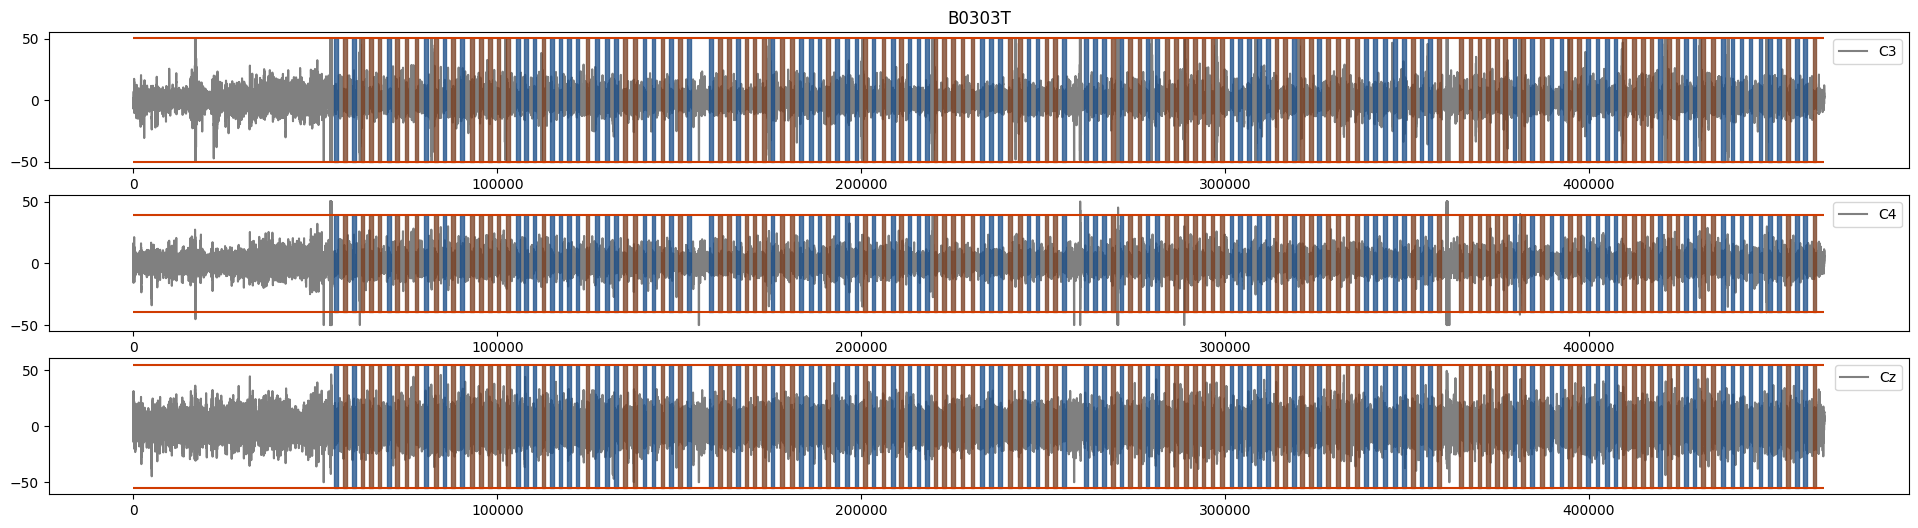

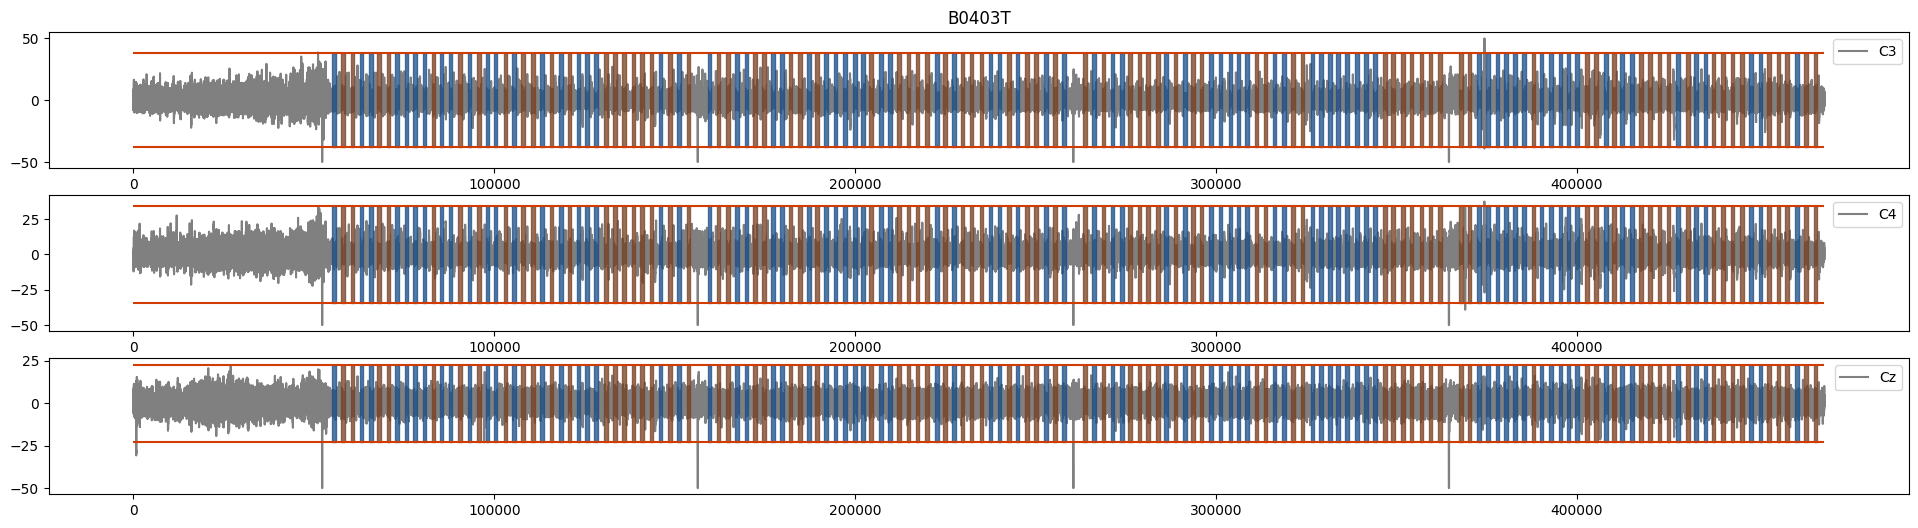

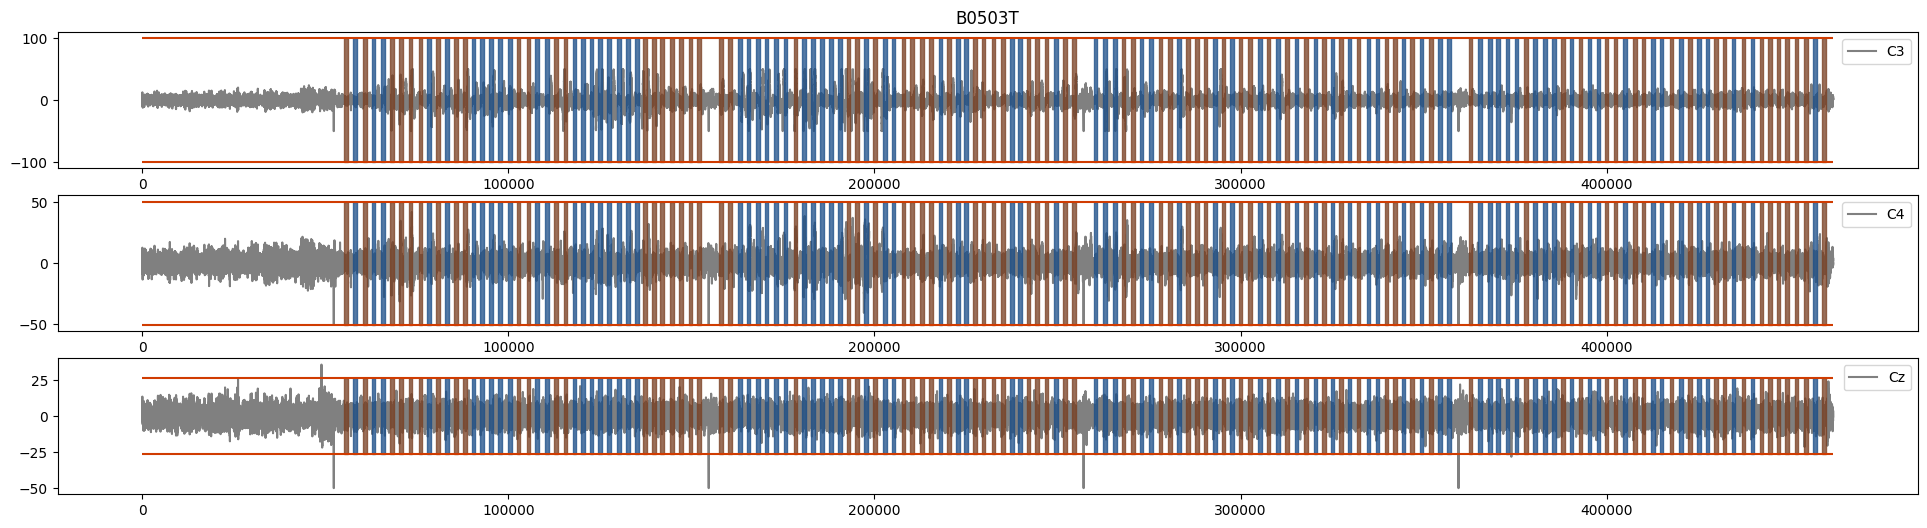

In [31]:
for i in range(len(fics))[2 :: 3] :
    plot_signal(df_train_csv[i], parts[i], hands0[i], hands1[i], canals = eeg_canals, title = notes[i])

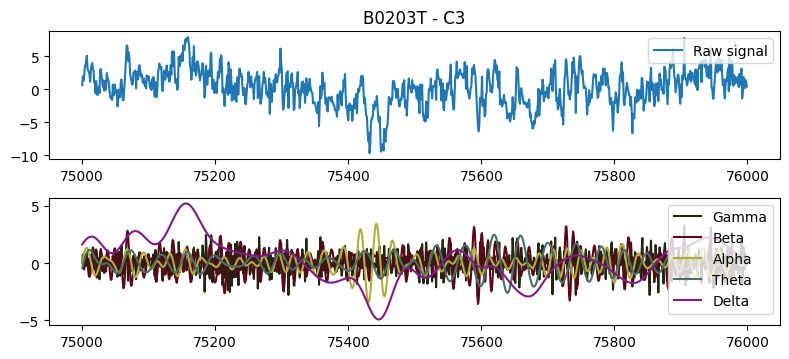

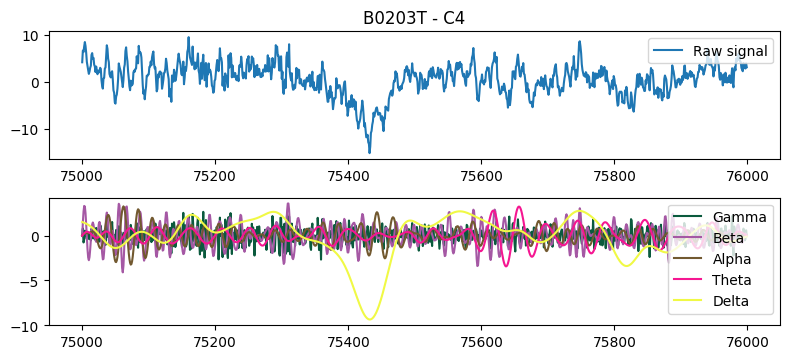

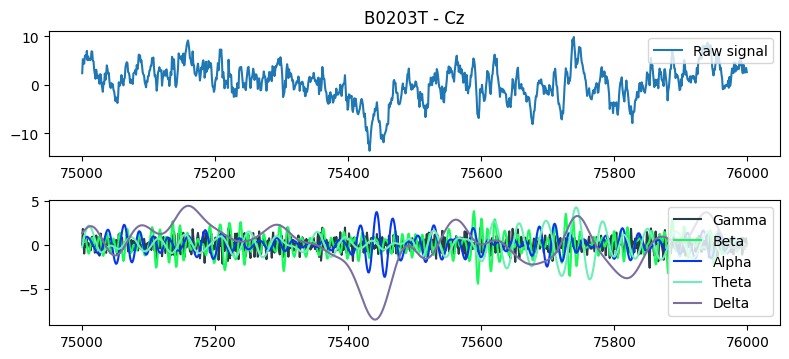

In [32]:
###
# Test de décomposition des signaux en bandes de fréquences spécifiques compatibles avec les répartitions usuelles
# dans le domaine des EEG ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
###
k  = 75 # 144
r  = range(int(scope * (k + 0)), int(scope * (k + 1)))
it = 5
nm = notes[it] + ' - '

for col in eeg_canals :
    data = df_train_csv[it].loc[r, col]
    r3   = {band : bandpass_filter(data, b, a) for band, (b, a) in butter_coeff.items()}
    
    plot_wavelets(data, r3, label = nm + col)

In [34]:
# res = share_out(df_train_csv[0], hands0[0], hands1[0], scope, eeg_canals)

# res.fillna(0, inplace = True)

In [36]:
res = pd.concat([share_out(train, h0, h1, scope, eeg_canals) for train, h0, h1 in zip(df_train_csv, hands0, hands1)])

res.reset_index(drop = True, inplace = True)
res.fillna(0, inplace = True)

res

,data_split,S_0,S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,...,S_994,S_995,S_996,S_997,S_998,S_999,hand,C3_dum,C4_dum,Cz_dum
0,55889,-4.425116,-3.628595,-2.337682,-3.601129,-0.778210,-1.321431,1.184100,2.984665,3.466850,...,2.182040,3.308156,6.213474,2.673381,5.465782,4.626535,0,1.0,0.0,0.0
1,55889,5.334554,5.502403,6.485084,6.689555,5.282673,3.390555,1.895171,0.460822,-0.601205,...,-0.213626,0.167849,0.823987,-1.644923,-2.829023,-3.479057,0,0.0,1.0,0.0
2,55889,-3.680476,-2.920577,-2.475013,-2.548257,-0.543221,-0.726329,0.430304,0.158694,0.891127,...,5.883879,6.161593,7.656977,6.909285,7.461662,4.449531,0,0.0,0.0,1.0
3,62817,-1.635767,-0.238041,-2.072175,-2.542153,-1.940948,-3.106737,-1.727321,0.677501,0.549325,...,-4.074159,-2.847333,-3.250172,-1.757839,0.289921,0.442512,0,1.0,0.0,0.0
4,62817,-2.471962,-0.915541,-0.564584,-2.960250,-2.578775,-0.842298,0.186160,2.426184,4.266423,...,-2.737469,-3.045701,-3.027390,-4.113832,-4.275578,-4.995804,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6115,439354,7.326007,6.764347,7.570208,7.008547,6.739927,6.544567,4.200244,4.664225,4.737485,...,2.002442,0.952381,3.321123,3.052503,-0.488400,-0.561661,1,0.0,1.0,0.0
6116,439354,7.619048,8.962149,10.158730,9.719170,10.036630,8.766789,7.789988,7.301587,8.986569,...,-0.488400,2.075702,4.078144,3.980464,3.418803,3.785104,1,0.0,0.0,1.0
6117,456427,-8.156288,-7.545788,-7.399267,-7.326007,-5.665446,-4.175824,-3.614164,-2.637363,-3.101343,...,-2.148962,-2.271062,-0.610501,-1.050061,1.172161,0.268620,1,1.0,0.0,0.0
6118,456427,-4.615385,-3.418803,-2.417582,-1.782662,-1.074481,-0.293040,0.708181,1.367521,2.539683,...,-1.904762,-2.466422,-3.076923,-1.758242,-1.391941,-2.857143,1,0.0,1.0,0.0


In [22]:
df_X = res.drop(columns = ['data_split', 'hand', 'C3_dum', 'C4_dum', 'Cz_dum'])
y = res['hand']

X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size = .2)

scaler = preprocessing.StandardScaler()

X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# K-plus proches voisins
clf1 = neighbors.KNeighborsClassifier()
# SVM (support vector machine)[, 'auto']
clf2 = svm.SVC(gamma = 'scale')
# RandomForest
clf3 = ensemble.RandomForestClassifier(n_jobs = -1)

Voting_clf = VotingClassifier(estimators = [('knn', clf1), ('svm', clf2), ('rf', clf3)], voting = 'hard')
# cv3        = model_selection.KFold(n_splits = 3, random_state = 42, shuffle = True)

for clf in [clf1, clf2, clf3] :
    print(f"● {clf} :")

    scores : dict = model_selection.cross_validate(clf, X_train, y_train, cv = 3, scoring = ['accuracy'])
    
    # r = abs(scores['test_neg_mean_squared_error'])
    # print(f"  - Mean square ;{r.mean(): .3} (±{r.std(): .2})")
    r = scores['test_accuracy']
    print(f"  - Accuracy    ;{r.mean(): .3} (±{r.std(): .2})")
    print()

● KNeighborsClassifier() :
  - Accuracy    ; 0.683 (± 0.038)

● SVC() :
  - Accuracy    ; 0.744 (± 0.014)

● RandomForestClassifier(n_jobs=-1) :
  - Accuracy    ; 0.638 (± 0.0092)



In [24]:
params = {
    # K-plus proches voisins
    'knn__n_neighbors' : range(2, 5),
    # SVM
    'svm__C'      : [0.1, 1, 5],
    'svm__kernel' : ['linear', 'sigmoid', 'rbf'],
    # RandomForest
    # 'rf__max_features'      : ['sqrt', 'log2', None],
    # 'rf__min_samples_split' : range(2, 32, 2),
    # , ('rf', clf3), ('rf', clf3)
    'estimators': [[('knn', clf1), ('svm', clf2)], [('knn', clf1), ('svm', clf2)]] 
    }

grid = model_selection.GridSearchCV(estimator = Voting_clf, param_grid = params, cv = 5) \
    .fit(X_train_scaled, y_train)

# parametres = {'max_features' : ['log2', 'sqrt', None], 'min_samples_split' : range(2, 32, 2)}

# vclf = model_selection.GridSearchCV(estimator = clf3, param_grid = parametres, cv = 3) \
#     .fit(X_train_scaled, y_train)

In [25]:
print(grid.best_estimator_)
print(grid.best_score_)
print('score train :', grid.score(X_train_scaled, y_train))
print('score test :', grid.score(X_test_scaled, y_test))

# print(vclf.best_estimator_, vclf.best_params_)
# print(vclf.best_score_)

# print('score train :', grid.score(X_train_scaled, y_train), vclf.score(X_train_scaled, y_train))
# print('score test :', grid.score(X_test_scaled, y_test), vclf.score(X_test_scaled, y_test))

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=2)),
                             ('svm', SVC(C=0.1))])
0.8114583333333334
score train : 0.971875
score test : 0.875


In [ ]:
df_train_cpy, event_start = fancy_df(df_train_csv, df_label_csv['EventType'], hands, scope)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = (24, 5), sharey = True)
sig = .05

axes.plot(df_train_csv['C3'])

for p in event_start :
    axes.axvspan(p[0] - scope / 2, p[0] + 1.5 * scope, facecolor = 'orangered', alpha = .5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Score')

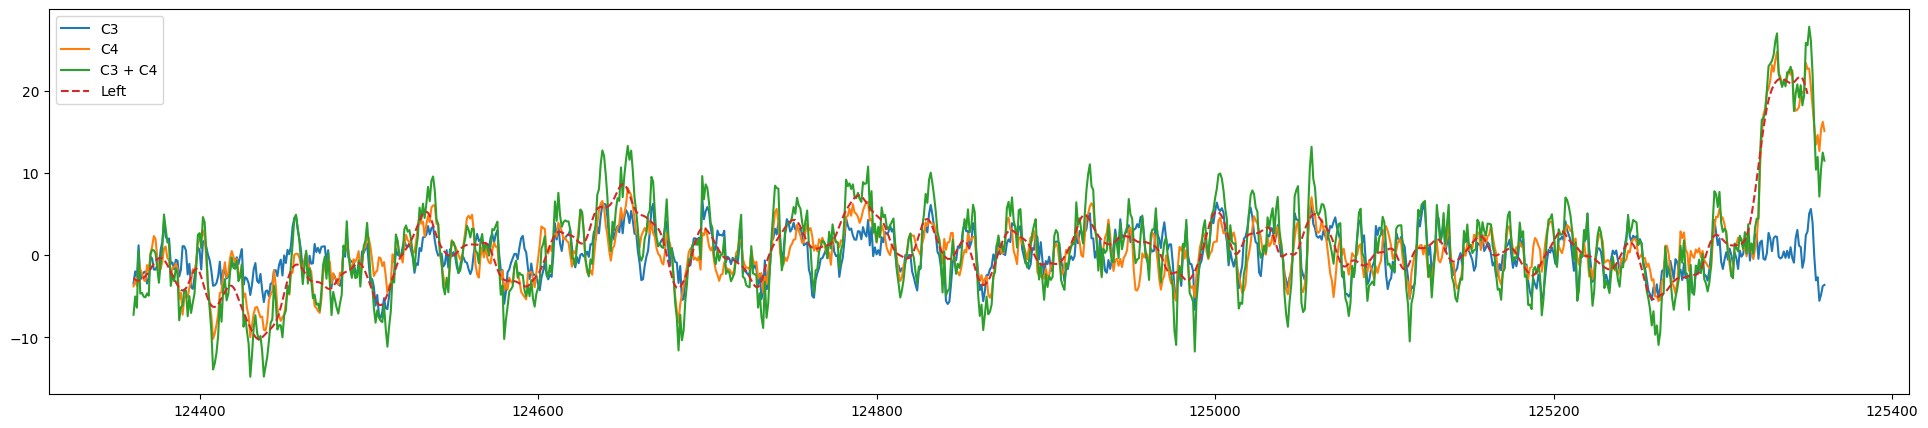

In [52]:
pos    = 16
start  = event_start[pos][0]
end    = start + scope
raw    = df_train_cpy['C3_4'][start : end]
smooth = raw.copy()
n      = 5
alpha  = 1 / 3
dec    = int(n / alpha)

plt.figure(figsize = (24, 5))

plot_window(df_train_csv, ['C3', 'C4', 'C3 + C4'], start, scope)

# Lissage des hautes fréquences
for _ in range(n) :
    smooth = simple_exponential_smoothing(smooth, alpha, 0)

smooth = pd.Series(index = range(start, end + n - dec), data = smooth[dec :])

plt.plot(smooth, '--', label = hands[event_start[pos][1]])
# plt.plot(raw - smooth, label = hands[event_start[pos][1]])
plt.legend()
plt.show()

In [ ]:
raw_csv = df_train_csv[['C3', 'Cz', 'C4']]
raw_mne = mne.io.RawArray(raw_csv.T * 1e-6, mne.create_info(raw_csv.columns.tolist(), SAMPLE_RATE, ch_types = 'eeg'))

In [ ]:
raw_mne.plot();

In [ ]:
# ###
# def eeg_spliting(signal : list, wavelet : str = 'db4', level : int = 5) :
#     coeffs = pywt.wavedec(signal, wavelet, level)
    
#     # Visualiser le signal original et les coefficients
#     _, ax = plt.subplots(len(coeffs) + 1, 1, figsize = (12, 8))
    
#     ax[0].plot(signal, label =' Signal EEG synthétique')
#     ax[0].legend(loc = 'upper right')

#     for i, coeff in enumerate(coeffs) :
#         ax[i + 1].plot(coeff, label = f'Coefficients niveau {i}')
#         ax[i + 1].legend(loc = 'upper right')

#     plt.tight_layout()
#     plt.show()

# fig, ax = plt.subplots(1, 3, figsize = (20, 3), sharey = True)
# spectrogram_fromEEG(raw, SAMPLE_RATE, 10, 50, axs = ax[0])
# spectrogram_fromEEG(smooth, SAMPLE_RATE, 10, 50, axs = ax[1])
# spectrogram_fromEEG(raw - smooth, SAMPLE_RATE, 10, 50, axs = ax[2])
# plt.show();

# sig_C3 = df_train_csv['C3']'Cz', 
# sig_C4 = df_train_csv['C4'][START : START + SCOPE]
# sig_cz = df_train_csv['Cz'][START : START + SCOPE]

# plt.figure(figsize = (20, 5))
# plt.plot(sig_C3, color = 'cornflowerblue')
# plt.plot(sig_cz, color = 'orangered')
# plt.plot(sig_C4, color = 'green')

# plt.figure(figsize = (20, 5))
# plt.plot(stats.zscore(sig_C3), color = 'cornflowerblue')
# plt.plot(stats.zscore(sig_cz), color = 'orangered')
# plt.plot(stats.zscore(sig_C4), color = 'green')
# plt.plot(stats.zscore(sig_C3 + sig_C4), color = 'magenta')
# plt.show();

"""
rw      = df_train_csv['C3'] # df_train_pkl['C3'][0]
rz      = rw.copy()
ro      = rw.copy()

# for _ in range(n) :
#     rz = Simple_exponential_smoothing(rz, alpha, 0)
#     ro = Simple_exponential_smoothing(ro, alpha)

recal = 

# fig, ax = plt.subplots()
# ax1 = fig.add_axes()
# fig.add_gridspec(x = [x[0] for x in event_start], y = np.zeros(120))
# ax.grid(axis = "x")

# plt.xticks(y_pos, bars, color='orange', rotation=45, fontweight='bold', fontsize='17', horizontalalignment='right')
# plt.tick_params(axis = 'x', colors = 'red', direction = 'out', length = 13) #, width =3

plt.plot(stats.zscore(df_train_csv['C3']), color = 'cornflowerblue')
plt.plot(stats.zscore(df_train_csv['Cz']))
plt.plot(stats.zscore(df_train_csv['C4']))
# plt.plot(stats.zscore(rz[recal: ]), 'm')
# plt.plot(stats.zscore(ro[recal: ]), '--', color = 'blue')
# """